In [ ]:
!pip install markov_clustering

In [ ]:
import pandas as pd 
import networkx as nx
from matplotlib.pyplot import figure
import csv
import markov_clustering as mc
from scipy.stats import hypergeom
from sklearn.cluster import KMeans

In [ ]:
#data = pd.read_csv('C:/Users/lucy_/Documents/GitHub/Bioinf1/data/disease_interactome.tsv',sep='\t')
data = pd.read_csv('disease_interactome.tsv',sep='\t')
data#.head()

,interactor A gene symbol,interactor B gene symbol,interactor A Uniprot AC,interactor B Uniprot AC
0,A2M,ENO2,P01023,P09104
1,ABCA1,IKBKG,O95477,Q9Y6K9
2,ABL1,BCL2L1,P00519,Q07817
3,ABL1,PRDX1,P00519,Q06830
4,ABL1,RB1,P00519,P06400
...,...,...,...,...
13212,SAP25,PML,Q8TEE9,P29590
13213,MTRNR2L1,PRDX1,P0CJ68,Q06830
13214,LUCAT1,PRDX1,-,Q06830
13215,OCLN,GJB1,Q16625,P08034


In [ ]:
nx_data = data[['interactor A gene symbol', 'interactor B gene symbol']]
nx_data.head()

,interactor A gene symbol,interactor B gene symbol
0,A2M,ENO2
1,ABCA1,IKBKG
2,ABL1,BCL2L1
3,ABL1,PRDX1
4,ABL1,RB1


In [ ]:
G = nx.Graph()
G = nx.from_pandas_edgelist(nx_data, 'interactor A gene symbol', 'interactor B gene symbol')
nodes_cardinality = G.number_of_nodes()
edges_cardinality = G.number_of_edges()

In [ ]:
nodes_cardinality

6318

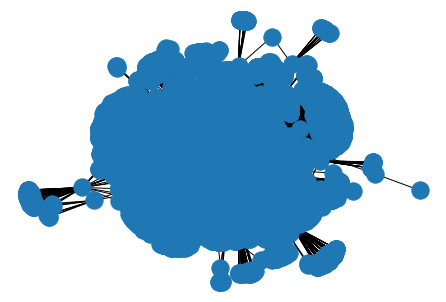

In [ ]:
nx.draw(G)

2.2

In [ ]:
def get_genes_symbols(filepath):
    with open(filepath, 'r') as tsv_in:
        reader = csv.reader(tsv_in, delimiter='\t')
        _ = reader.__next__()

        genes_ids = set()
        for line in reader:
            genes_ids.add(str(line[1].strip()))

    return genes_ids

In [ ]:
 seed_genes = get_genes_symbols('/content/approved_genes.tsv')

In [ ]:
matrix = nx.to_scipy_sparse_matrix(G) # get the adjacency matrix (in sparse form)
result = mc.run_mcl(matrix) # run MCL with default parameters
clusters = mc.get_clusters(result) # get clusters

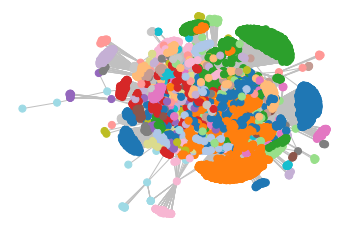

In [ ]:
mc.draw_graph(matrix, clusters, node_size=50, with_labels=False, edge_color="silver")#, pos=positions, node_size=50, with_labels=False, edge_color="silver")

In [ ]:
# Q = mc.modularity(matrix=result, clusters=clusters)
# Q
c=0
to_remove=[]
for i in range(len(clusters)):
  if len(clusters[i])>=10:
    c+=1
  else:
    to_remove.append(i)
    #print(len(clusters[i]))
print(len(clusters), "clusters with ", c, "longer than 10")
to_remove

62 clusters with  53 longer than 10


[22, 31, 33, 41, 43, 51, 59, 60, 61]

In [ ]:
clusters_rem=clusters.copy()
for i in reversed(to_remove):
  del clusters_rem[i]
len(clusters_rem)

53

In [ ]:
final=pd.DataFrame(columns=["module_ID", "N_seed_genes", "N_genes", "seed_gene_IDs", "all_gene_IDs", "p-value"])
final



[M,n,N,x]=[1000,10,7,2]
pvalue = hypergeom.sf(x-1, M, n, N)
print(pvalue)


for j, module in enumerate(clusters_rem):
  c=0
  l=[]
  f=[]
  for i in module:
    if list(G.nodes)[i] in seed_genes:
      c+=1
      l.append(i)
  f.append(j)
  f.append(c)
  f.append(len(module))
  f.append(l)
  f.append(module)

  M=len(G.nodes) # K = population =M
  n=len(seed_genes) # k = objects with feature = n
  N=len(module) # N = draws = N
  x=c # n = successes in draws = x
  pvalue = hypergeom.sf(x-1, M, n, N)
  f.append(pvalue)
  ff=pd.DataFrame([f], columns=["module_ID", "N_seed_genes", "N_genes", "seed_gene_IDs", "all_gene_IDs", "p-value"])
  final=final.append(ff, ignore_index=True)

0.0018418701664548514


In [ ]:
final[final['p-value']<0.05]

,module_ID,N_seed_genes,N_genes,seed_gene_IDs,all_gene_IDs,p-value


In [ ]:
final.sort_values(by=['p-value'])[:10]

,module_ID,N_seed_genes,N_genes,seed_gene_IDs,all_gene_IDs,p-value
42,42,1,10,[1203],"(212, 1201, 1203, 2226, 2227, 2228, 2229, 2231...",0.161185
22,22,1,11,[56],"(55, 56, 86, 87, 88, 89, 92, 1716, 4265, 6118,...",0.175813
48,48,1,11,[596],"(595, 596, 675, 827, 889, 2684, 3231, 3373, 50...",0.175813
47,47,1,11,[566],"(561, 565, 566, 2280, 2497, 3675, 4807, 4862, ...",0.175813
18,18,1,12,[35],"(35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 5689,...",0.190187
41,41,1,12,[210],"(209, 210, 211, 213, 1823, 4395, 5687, 5875, 5...",0.190187
52,52,1,12,[1180],"(1179, 1180, 1206, 2495, 3311, 3313, 3341, 442...",0.190187
49,49,1,12,[1535],"(649, 658, 674, 808, 967, 1241, 1535, 4720, 47...",0.190187
32,32,1,13,[85],"(84, 85, 336, 1189, 2813, 3597, 3689, 4401, 48...",0.204313
24,24,1,13,[58],"(58, 132, 225, 492, 1763, 1806, 4380, 4546, 58...",0.204313


In [ ]:
from scipy.stats import hypergeom

[M,n,N,x]=[1000,10,7,2]
pvalue = hypergeom.sf(x-1, M, n, N)
print(pvalue)

0.0018418701664548514


In [ ]:
from  DIAMOnD3 import *

In [ ]:
outfile_name="/content/outfile_name.tsv"
added_nodes = DIAMOnD(G, seed_genes, max_number_of_added_nodes=200, alpha=1, outfile=outfile_name)
print("\n results have been saved to '%s' \n" % outfile_name)

DIAMOnD(): ignoring 30 of 110 seed genes that are not in the network

 results have been saved to '/content/outfile_name.tsv' 



In [ ]:
added_nodes[:3]

[('EGFR', 20, 20, array([8.63046814e-40])),
 ('HNRNPK', 19, 19, array([1.16431222e-37])),
 ('TRIM25', 19, 19, array([1.515454e-37]))]

In [ ]:
added_nodes_new = []

for row in added_nodes:
  new_row = list(row[0:3])
  new_row.append(row[3][0])
  added_nodes_new.append(new_row)

added_nodes_new[:5]

[['EGFR', 20, 20, 8.630468140178172e-40],
 ['HNRNPK', 19, 19, 1.1643122221052507e-37],
 ['TRIM25', 19, 19, 1.5154540033751182e-37],
 ['HSP90AA1', 19, 19, 1.96535441062697e-37],
 ['HNRNPA1', 19, 19, 2.5398426229640867e-37]]

In [ ]:
diamond_df = pd.DataFrame(added_nodes_new, index=None, 
                          columns=['GeneSymbol', 'Degree', 'No. of neighbors', 'p-value'])
diamond_df

,GeneSymbol,Degree,No. of neighbors,p-value
0,EGFR,20,20,8.630468e-40
1,HNRNPK,19,19,1.164312e-37
2,TRIM25,19,19,1.515454e-37
3,HSP90AA1,19,19,1.965354e-37
4,HNRNPA1,19,19,2.539843e-37
...,...,...,...,...
195,MSN,7,7,2.749709e-10
196,CRYAB,7,7,2.821263e-10
197,STUB1,7,7,2.894407e-10
198,PTPN11,7,7,2.969170e-10


In [ ]:
diamond_df.to_csv("/content/diamond_data.tsv", index=None, sep="\t")